# Linear regression with ``gluon``

Now that we've implemented a whole neural network from scratch, using nothing but ``mx.ndarray`` and ``mxnet.autograd``, let's see how we can make the same model while doing a lot less work. 

Again, let's import some packages, this time adding ``mxnet.gluon`` to the list of dependencies.

In [1]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon

## Set the context

We'll also want to set a context to tell gluon where to do most of the computation.

In [2]:
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()
data_ctx = ctx
model_ctx = ctx

## Build the dataset

Again we'll look at the problem of linear regression and stick with the same synthetic data. 

In [3]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2
    
X = nd.random_normal(shape=(num_examples, num_inputs))
noise = 0.01 * nd.random_normal(shape=(num_examples,))
y = real_fn(X) + noise

## Load the data iterator

We'll stick with the ``DataLoader`` for handling our data batching.

In [4]:
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y),
                                      batch_size=batch_size, shuffle=True)

## Define the model

When we implemented things from scratch, 
we had to individually allocate parameters 
and then compose them together as a model. 
While it's good to know how to do things from scratch, 
with `gluon`, we can just compose a network from predefined layers. 
For a linear model, the appropriate layer is called `Dense`. 
It's called a *dense* layer because every node in the input 
is connected to every node in the subsequent layer. 
That description seems excessive 
because we only have one (non-input) layer here, 
and that layer only contains one node!
But in subsequent chapters we'll typically work 
with networks that have multiple outputs, 
so we might as well start thinking in terms of layers of nodes. 
Because a linear model consists of just a single `Dense` layer, we can instantiate it with one line.

As in [the previous notebook](linear-regression-scratch.ipynb), 
we have an input dimension of 2 and an output dimension of 1. 
the most direct way to instantiate a ``Dense`` layer with these dimensions
is to specify the number of inputs and the number of outputs. 

In [5]:
net = gluon.nn.Dense(1, in_units=2)

That's it! We've already got a neural network. 
Like our hand-crafted model in the previous notebook, 
this model has a weight matrix and bias vector.

In [6]:
print(net.weight)
print(net.bias)

Parameter dense0_weight (shape=(1, 2), dtype=float32)
Parameter dense0_bias (shape=(1,), dtype=float32)


Here, `net.weight` and `net.bias` are not actually NDArrays.
They are instances of the `Parameter` class.
We use `Parameter` instead of directly accessing NDAarrays for several reasons. 
For example, they provide convenient abstractions for initializing values.
Unlike NDArrays, Parameters can be associated with multiple contexts simultaneously.
This will come in handy in future chapters when we start thinking about distributed learning across multiple GPUs.

In `gluon`, all neural networks are made out of Blocks (`gluon.Block`).
Blocks are just units that take inputs and generate outputs.
Blocks also contain parameters that we can update. 
Here, our network consists of only one layer, 
so it's convenient to access our parameters directly. 
When our networks consist of 10s of layers, this won't be so fun.
No matter how complex our network, 
we can grab all its parameters by calling `collect_params()` as follows:

In [7]:
net.collect_params()

dense0_ (
  Parameter dense0_weight (shape=(1, 2), dtype=float32)
  Parameter dense0_bias (shape=(1,), dtype=float32)
)

The returned object is a `gluon.parameter.ParameterDict`. 
This is a convenient abstraction for retrieving and manipulating groups of Parameter objects.
Most often, we'll want to retrieve all of the parameters in a neural network:

In [8]:
type(net.collect_params())

mxnet.gluon.parameter.ParameterDict

## Initialize parameters
Once we initialize our Parameters, we can access their underlying data and context(s),
and we can also feed data through the neural network to generate output.
However, we can't get going just yet. 
If we try invoking your model by calling ``net(nd.array([[0,1]]))``, 
we'll confront the following hideous error message:

```RuntimeError: Parameter dense1_weight has not been initialized...```

That's because we haven't yet told ``gluon`` what the *initial values* for our parameters should be!
We initialize parameters by calling the `.initialize()` method of a ParameterDict. 
We'll need to pass in two arguments. 

* An initializer, many of which live in the `mx.init` module. 
* A context where the parameters should live. In this case we'll pass in the `model_ctx`. Most often this will either be a GPU or a list of GPUs. 

*MXNet* provides a variety of common initializers in ``mxnet.init``.
To keep things consistent with the model we built by hand, 
we'll initialize each parameter by sampling from a standard normal distribution, 
using `mx.init.Normal(sigma=1.)`.

In [9]:
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

## Deferred Initialization

When we call ``initialize``, ``gluon`` associates each parameter with an initializer.
However, the *actual initialization* is deferred until we make a first forward pass. 
In other words, the parameters are only initialized when they're needed. 
If we try to call `net.weight.data()` we'll get the following error:

``DeferredInitializationError: Parameter dense2_weight has not been initialized yet because initialization was deferred. Actual initialization happens during the first forward pass. Please pass one batch of data through the network before accessing Parameters.``

Passing data through a `gluon` model is easy. 
We just sample a batch of the appropriate shape and call `net` 
just as if it were a function. 
This will invoke `net`'s `forward()` method.

In [11]:
example_data = nd.array([[4,7]], ctx=data_ctx)
net(example_data)


[[-4.222597]]
<NDArray 1x1 @gpu(0)>

Now that `net` is initialized, we can access each of its parameters. 

In [12]:
print(net.weight.data())
print(net.bias.data())


[[-0.34304565 -0.40720204]]
<NDArray 1x2 @gpu(0)>

[0.]
<NDArray 1 @gpu(0)>


## Shape inference

Recall that previously, we instantiated our network with `gluon.nn.Dense(1, in_units=2)`. 
One slick feature that we can take advantage of in ``gluon`` is shape inference on parameters. 
Because our parameters never come into action until we pass data through the network,
we don't actually have to declare the input dimension (`in_units`). 
Let's try this again, but letting `gluon` do more of the work:

In [13]:
net = gluon.nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

We'll elaborate on this and more of ``gluon``'s internal workings in subsequent chapters.

## Define loss

Instead of writing our own loss function we're just going to access squared error by instantiating ``gluon.loss.L2Loss``. Just like layers, and whole networks, a loss in gluon is just a `Block`.

In [14]:
square_loss = gluon.loss.L2Loss()

## Optimizer
Instead of writing stochastic gradient descent from scratch every time, we can instantiate a ``gluon.Trainer``, passing it a dictionary of parameters. Note that the ``SGD`` optimizer in ``gluon`` also has a few bells and whistles that you can turn on at will, including *momentum* and *clipping* (both are switched off by default). These modifications can help to converge faster and we'll discuss them later when we go over a variety of optimization algorithms in detail.

In [15]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})

## Execute training loop

You might have noticed that it was a bit more concise to express our model in ``gluon``. For example, we didn't have to individually allocate parameters, define our loss function, or implement stochastic gradient descent. The benefits of relying on ``gluon``'s abstractions will grow substantially once we start working with much more complex models. But once we have all the basic pieces in place, the training loop itself is quite similar to what we would do if implementing everything from scratch. 

To refresh your memory. For some number of ``epochs``, we'll make a complete pass over the dataset (``train_data``), grabbing one mini-batch of inputs and the corresponding ground-truth labels at a time. 

Then, for each batch, we'll go through the following ritual. So that this process becomes maximally ritualistic, we'll repeat it verbatim:

* Generate predictions (``yhat``) and the loss (``loss``) by executing a forward pass through the network.
* Calculate gradients by making a backwards pass through the network via ``loss.backward()``. 
* Update the model parameters by invoking our SGD optimizer (note that we need not tell ``trainer.step`` about which parameters but rather just the amount of data, since we already performed that in the initialization of ``trainer``).



In [16]:
epochs = 10
loss_sequence = []
num_batches = num_examples / batch_size

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.mean(loss).asscalar()
    print("Epoch %s, loss: %s" % (e, cumulative_loss / num_examples))
    loss_sequence.append(cumulative_loss)


Epoch 0, loss: 3.7838184527724983
Epoch 1, loss: 2.295749815192819
Epoch 2, loss: 1.3929292962759734
Epoch 3, loss: 0.8451676476236433
Epoch 4, loss: 0.5128228855913505
Epoch 5, loss: 0.3111709547152743
Epoch 6, loss: 0.18882083448367193
Epoch 7, loss: 0.11458220178950577
Epoch 8, loss: 0.06953518837084993
Epoch 9, loss: 0.042200489226426


## Visualizing the learning curve
Now let's check how quickly SGD learns the linear regression model by plotting the learning curve.

Text(0,0.5,'average loss')

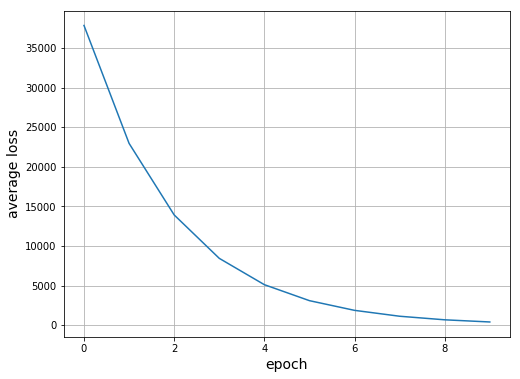

In [17]:
# plot the convergence of the estimated loss function 
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

As we can see, the loss function converges quickly to the optimal solution.

## Getting the learned model parameters

As an additional sanity check, since we generated the data from a Gaussian linear regression model, we want to make sure that the learner managed to recover the model parameters, which were set to weight $2,-3.4$ with an offset of $4.2$.
    

In [18]:
params = net.collect_params() # this returns a ParameterDict

print('The type of "params" is a ',type(params))

# A ParameterDict is a dictionary of Parameter class objects
# therefore, here is how we can read off the parameters from it.

for param in params.values():
    print(param.name,param.data())

The type of "params" is a  <class 'mxnet.gluon.parameter.ParameterDict'>
dense1_weight 
[[ 1.8881929 -3.0423238]]
<NDArray 1x2 @gpu(0)>
dense1_bias 
[3.8534913]
<NDArray 1 @gpu(0)>


## Conclusion 

As you can see, even for a simple example like linear regression, ``gluon`` can help you to write quick and clean code. Next, we'll repeat this exercise for multi-layer perceptrons, extending these lessons to deep neural networks and (comparatively) real datasets. 

## Next
[Binary classification with logistic regression](../chapter02_supervised-learning/logistic-regression-gluon.ipynb)

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)